In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import jax # type: ignore
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
from jax import vmap # type: ignore
import blackjax # type: ignore
import jax.scipy.stats as jss # type: ignore
from jax.scipy.special import logsumexp as lse # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
import numpy as onp # type: ignore

from util.train import reshape_emissions, logdensity_fn
from util.param import params_from_tree, sample_prior, initialize, to_train_array, log_prior, get_unravel_fn, join_trees, tree_from_params
from util.sample import sample_prior, sample_logpdf

from maf.density_models import MAF
from flax import nnx # type: ignore
from matplotlib import pyplot as plt # type: ignore
from inference.simulation_inference import sample_and_train
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb # type: ignore
from simulators.ssm import LGSSM

from datetime import date
import csv
import time
from functools import partial

import scienceplots # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Initialize model and simulate dataset

In [3]:
num_timesteps = 100 # Number of emissions timesteps
num_mcmc_steps = 1000 # Number of MCMC steps

state_dim = 1
emission_dim = 1
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 0.1

dynamics_weights  = 0.9 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.1

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 0.1

# Initialize params and props_prior_prior
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag= 0.1 * jnp.ones(m))
emission_bias_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(emission_dim), scale_diag= 1.0 * jnp.ones(emission_dim))


param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov']]

prior_tree = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_weights, emission_bias_dist, emission_input_weights, emission_covariance]]

is_constrained_tree = [[True, True], # The tree state at initialization
                       [True, True, True, False], 
                       [True, True, True, True]]

constrainers_tree  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector]] 

props = initialize(prior_tree, param_names, constrainers_tree)

### Sample ***true*** params and emissions

In [4]:
seed = int(time.time() * 1000)  # Milliseconds for more granularity
key = jax.random.PRNGKey(seed)

key, subkey = jr.split(key)
true_lgssm = LGSSM(state_dim, emission_dim)
true_param, x_param = sample_prior(key, props, 2)
true_cparam = to_train_array(true_param, props)
true_param.from_unconstrained(props)
_, observations = true_lgssm.simulate(subkey, true_param, num_timesteps)

## Train TAF model

In [5]:
lag = 10
din = emission_dim
n_params = to_train_array(x_param, props).shape[0]
dcond = lag * emission_dim + n_params
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 32
nhidden = 5

# Initialize models
model = MAF(din, nmades, dhidden, nhidden,'relu', dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
test_lgssm = LGSSM(state_dim, emission_dim)

# Sample parameters for first round
num_samples = 10
key, subkey = jr.split(key)
params_sample = sample_prior(subkey, props, num_samples) # Here, output params are in mixed constrained/unconstrained form
                                                              # The trainable params (given in prior by dist) are unconstrained
                                                              # whereas the not-trainable params (given in prior by arrays) are constrained
                                                              # In the trainer, the cond_params are appended to the dataset and then the params are converted
                                                              # to constrained form before being passed to the model for simulation. 
dataset = jnp.array([])
num_rounds = 2
params_samples_allrounds = []
for r in range(num_rounds):
    print(f"-Round {r}")

    # Add previous samples to samples
    params_samples_allrounds.append(params_sample)    

    # Sample SSM emissions and train TAF
    key, subkey1, subkey2 = jr.split(key, 3)
    model, dataset = sample_and_train(
        key = subkey1,
        model = model,
        ssmodel = test_lgssm,
        lag = lag,
        num_timesteps = num_timesteps, 
        props = props,
        params_sample = params_sample,
        prev_dataset = dataset, 
        num_epochs = 20,
        learning_rate = 1 * 1e-4,
        verbose=True
    )

    # Sample new parameters using TAF likelihood and MCMC
    print("-Sampling new parameters")

    ## Define TAF-based logdensity function
    def taf_logdensity_fn(cond_params):
        lagged_emissions = reshape_emissions(observations, lag)
        tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
        lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
        lp += log_prior(cond_params, props)
        return lp

    ## Initialize MCMC chain and kernel
    rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
    initial_cond_params = to_train_array(sample_prior(rng_key, props, 1)[0], props)
    taf_random_walk = blackjax.additive_step_random_walk(taf_logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
    taf_initial_state = taf_random_walk.init(initial_cond_params)
    taf_kernel = jax.jit(taf_random_walk.step)

    ## Run inference loop
    rng_key, sample_key1, sample_key2 = jax.random.split(rng_key, 3)
    taf_mcmc_states = inference_loop(sample_key1, taf_kernel, taf_initial_state, num_mcmc_steps)
    positions = taf_mcmc_states.position[-num_samples:]

    # Setup params for next round
    params_sample = []
    param_names = x_param._get_names()
    is_constrained_tree = x_param._is_constrained_tree()
    for cond_param in positions:
        unravel_fn = get_unravel_fn(x_param, props)
        unravel = unravel_fn(cond_param)
        tree = tree_from_params(x_param)
        new_tree = join_trees(unravel, tree, props)
        param = params_from_tree(new_tree, param_names, is_constrained_tree)
        params_sample.append(param)

# Add samples from final round
params_samples_allrounds.append(params_sample)

-Round 0
----Creating dataset
----Setting up data loaders
----Start training loop
--------Epoch 0, training loss: -48.74567413330078, validation loss: -73.53433227539062
--------Epoch 1, training loss: -48.800350189208984, validation loss: -73.5861587524414
--------Epoch 2, training loss: -48.854576110839844, validation loss: -73.63816833496094
--------Epoch 3, training loss: -48.90883255004883, validation loss: -73.69025421142578
--------Epoch 4, training loss: -48.96337890625, validation loss: -73.74247741699219
--------Epoch 5, training loss: -49.018402099609375, validation loss: -73.7951431274414
--------Epoch 6, training loss: -49.07408142089844, validation loss: -73.84854888916016
--------Epoch 7, training loss: -49.13055419921875, validation loss: -73.90299987792969
--------Epoch 8, training loss: -49.18791961669922, validation loss: -73.9583511352539
--------Epoch 9, training loss: -49.24641036987305, validation loss: -74.01441192626953
--------Epoch 10, training loss: -49.3061

In [6]:
# model.generate(jr.PRNGKey(0), 10, jnp.array([jnp.zeros(dcond)]*10))

def generate_emissions(key, emission_dim, model, cond_param, num_samples, lag, num_timesteps):

    all_emissions = []

    for n in range(num_samples):

        prev_lagged_emissions = jnp.zeros((lag, emission_dim))
        emissions = []

        for t in range(num_timesteps):

            condition_on = jnp.concatenate([cond_param, prev_lagged_emissions.flatten()])[None]
            key, subkey = jr.split(key)
            gen = model.generate(subkey, 1, condition_on)[0]
            new_emission = gen[-emission_dim:]
            prev_lagged_emissions = jnp.concatenate([prev_lagged_emissions[1:], new_emission[None]])
            emissions.append(new_emission)

        all_emissions.append(jnp.array(emissions))

    return jnp.array(all_emissions)


In [7]:
def generate_emission(key, emission_dim, model, cond_param, lag, num_timesteps):

    emissions = []

    def _step(carry, t):

        key, prev_lagged_emission = carry
        condition_on = jnp.concatenate([cond_param, prev_lagged_emission.flatten()])[None]
        key, subkey = jr.split(key)
        gen = model.generate(subkey, 1, condition_on)[0]
        new_emission = gen[-emission_dim:]
        prev_lagged_emission = jnp.concatenate([prev_lagged_emission[1:], new_emission[None]])
        carry = key, prev_lagged_emission

        return carry, new_emission
    
    key, subkey = jr.split(key)
    _, emissions = jax.lax.scan(_step, (key, jnp.zeros((lag, emission_dim))), jnp.arange(num_timesteps))    

    return jnp.array(emissions)

In [12]:
from jax.tree_util import tree_map
from util.train import to_train_array, get_sds
from util.sample import map_sims, sim_emissions

new_param = sample_prior(key, props, 10)[0]
cparam = to_train_array(new_param, props)

num_samples = 1
keys1 = jr.split(key, num_samples)
key, subkey = jr.split(key)

emissions1 = vmap(map_sims, in_axes=(0,None,None,None,None))(keys1, true_cparam, props, true_lgssm, num_timesteps)
emissions2 = generate_emissions(subkey, 1, model, cparam, num_samples, lag, num_timesteps)

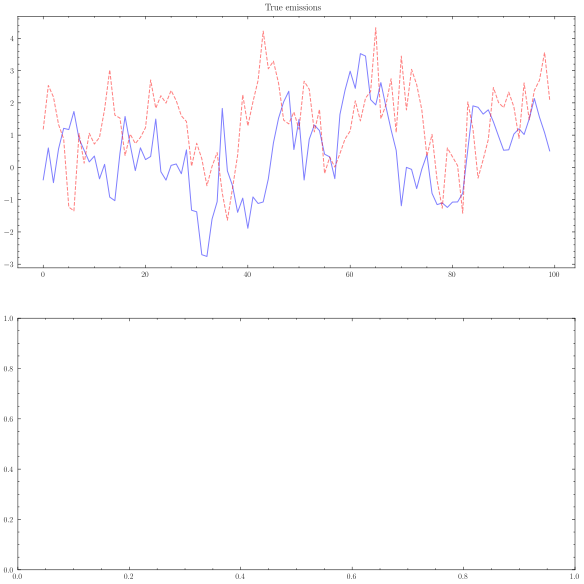

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))
for (e1, e2) in zip(emissions1, emissions2):
    ax[0].plot(e1, color='blue', alpha=0.5)
    ax[0].plot(e2, color='red', alpha=0.5)
    ax[0].set_title("True emissions")
plt.show()

In [14]:
from inference.diagnostics.two_sample import sq_maximum_mean_discrepancy as mmd

mmd(emissions1, emissions2)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# key, subkey = jr.split(key)
# for param in params_sample:
#     cparam = to_train_array(param, props)
#     emissions = generate_emissions(subkey, 1, model, cparam, 10, lag, 100)          

#     for emission in emissions:
#         plt.scatter(observations[:, 0], observations[:, 1], color='blue', label='Observations')
#         plt.scatter(emission[:, 0], emission[:, 1], color='red', alpha=0.5)
#         plt.show()  